# MLR - Model Selection

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('data/Housing.csv')
# Convert 'Yes' to 1 and 'No' to 0
df['mainroad'] = df['mainroad'].map({'yes': 1, 'no': 0})
df['guestroom'] = df['guestroom'].map({'yes': 1, 'no': 0})
df['basement'] = df['basement'].map({'yes': 1, 'no': 0})
df['hotwaterheating'] = df['hotwaterheating'].map({'yes': 1, 'no': 0})
df['airconditioning'] = df['airconditioning'].map({'yes': 1, 'no': 0})
df['prefarea'] = df['prefarea'].map({'yes': 1, 'no': 0})
df['furnishingstatus'] = df['furnishingstatus'].map({'unfurnished': 0, 'semi-furnished': 1, 'furnished':2})

# Center predicotrs - to make intercepts meaningful
df['area_z'] = (df.area - df.area.mean())/df.area.std()

df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_z
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2,1.045766
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2,1.755397
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,2.216196
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2,1.082630
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2,1.045766


In [3]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
area_z              0
dtype: int64

In [4]:
# STEP-1
predictors = ['area_z', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea']

coeffs = []
ts = []
ps = []
r2s = []
adj_r2s = []
aics = []
for predictor in predictors:
    Y = df['price']
    X = df[predictor]
    model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

    coeff = model.params
    # Collect statistics
    t_stats = model.tvalues           # t-statistics for coefficients
    p_values = model.pvalues          # p values for coefficients  
    r2 = model.rsquared               # R-squared
    adj_r2 = model.rsquared_adj       # Adjusted R-squared
    aic = model.aic                   # AIC (Akaike Information Criterion)

    ts.append(t_stats.iloc[1])
    ps.append(p_values.iloc[1])
    coeffs.append(coeff.iloc[1])
    r2s.append(r2)
    adj_r2s.append(adj_r2)
    aics.append(aic)

step1_df = pd.DataFrame([predictors,coeffs, ts, ps, r2s, adj_r2s, aics]).T
step1_df.columns = ['predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']
step1_df.sort_values(by = 't')

,predictor,Coeff,t,p,R2,AdjR2,AIC
7,hotwaterheating,831366.846154,1.954126,0.050686,0.008663,0.006837,17286.336038
6,basement,732649.251043,4.442922,0.000009,0.03499,0.033213,17271.666436
5,guestroom,1248351.282216,6.40095,0.0,0.065289,0.063568,17254.280398
10,prefarea,1453746.926147,7.504173,0.0,0.108753,0.107112,17228.329904
9,parking,834490.482266,7.899716,0.0,0.147758,0.146189,17203.9402
1,bedrooms,928788.118932,8.246172,0.0,0.134318,0.132724,17212.468263
8,airconditioning,1821280.903111,10.667289,0.0,0.205167,0.203704,17165.93275
2,bathrooms,1926558.890106,10.84936,0.0,0.267853,0.266505,17121.160753
0,area_z,1002550.669431,11.441103,0.0,0.287293,0.285981,17106.494318
3,stories,907116.903197,11.874186,0.0,0.176999,0.175483,17184.912931


I want to consider area_z as the first predictor:
1. Very high t-stat (Statistically significant)
2. Highest R2 value. It explains more variation in price than any other predictor alone.

We'll check residuals to check if there is a better form in which we can consider this variable.

In [5]:
Y = df['price']
X = df['area_z']
model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')
predictions = model.get_prediction(sm.add_constant(X)).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
residuals = Y - predictions['mean']
model.rsquared

0.2872931546811468

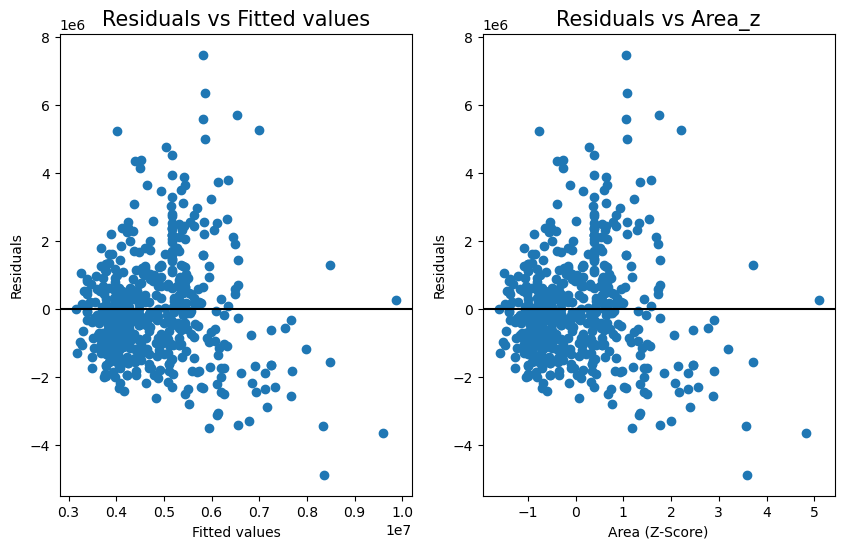

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
axes = ax.flatten()
axes[0].scatter(x=predictions['mean'], y=residuals)
axes[0].set_title('Residuals vs Fitted values', fontsize=15)
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='black')


axes[1].scatter(x=X, y=residuals)
axes[1].set_title('Residuals vs Area_z', fontsize=15)
axes[1].set_xlabel('Area (Z-Score)')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='black')
plt.show()

The residuals are not very neat.
1. Heteroskedasticity is there, but we addressed it by considering standard robust errors.
2. Issue is that the expected value of residuals is not 0 at the right end of fitted values. Which means there is a bias with large, pricey houses. The predictions would be upper biased. 

In [7]:
Y = df['price']
X = np.log(df['area'])
model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')
predictions = model.get_prediction(sm.add_constant(X)).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
residuals = Y - predictions['mean']
model.rsquared

0.3149798735875545

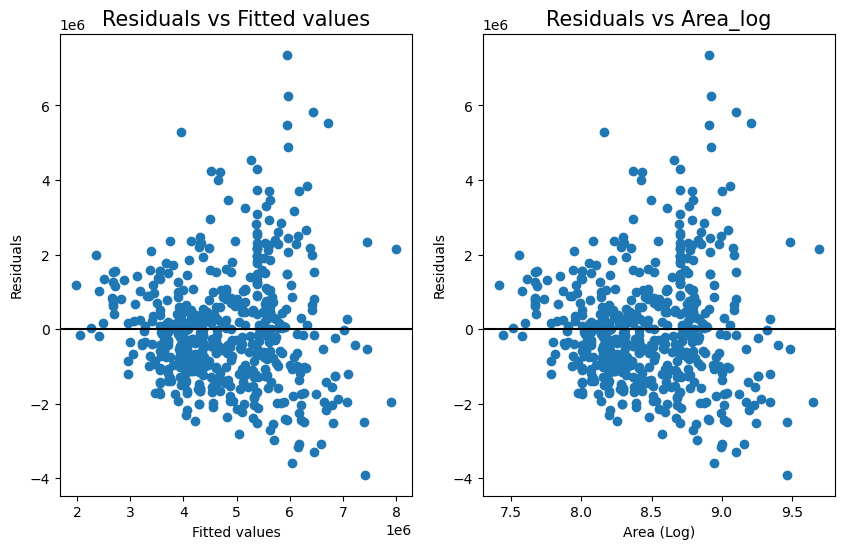

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
axes = ax.flatten()
axes[0].scatter(x=predictions['mean'], y=residuals)
axes[0].set_title('Residuals vs Fitted values', fontsize=15)
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='black')


axes[1].scatter(x=X, y=residuals)
axes[1].set_title('Residuals vs Area_log', fontsize=15)
axes[1].set_xlabel('Area (Log)')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='black')
plt.show()

Residuals are neater than above. 
1. The explained variance improved.
2. Bias is till there with large houses. This could be due to non-linearity. Should check if it remains after adding other variables.

In [9]:
# STEP-2
predictors = ['bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea']

coeffs = []
ts = []
ps = []
r2s = []
adj_r2s = []
aics = []

area_log_coeffs = []
area_log_ts = []
area_log_ps = []
df['area_log'] = np.log(df['area'])
for predictor in predictors:
    Y = df['price']
    X = df[['area_log',predictor]]
    model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

    coeff = model.params
    # Collect statistics
    t_stats = model.tvalues           # t-statistics for coefficients
    
    p_values = model.pvalues          # p values for coefficients  
    r2 = model.rsquared               # R-squared
    adj_r2 = model.rsquared_adj       # Adjusted R-squared
    aic = model.aic                   # AIC (Akaike Information Criterion)

    ts.append(t_stats.iloc[2])
    ps.append(p_values.iloc[2])
    coeffs.append(coeff.iloc[2])
    r2s.append(r2)
    adj_r2s.append(adj_r2)
    aics.append(aic)

    area_log_coeff = coeff.iloc[1]
    area_log_coeffs.append(area_log_coeff)
    area_log_t = t_stats.iloc[1]
    area_log_ts.append(area_log_t)
    area_log_p = p_values.iloc[1]
    area_log_ps.append(area_log_p)

step2_df = pd.DataFrame([area_log_coeffs, area_log_ts, area_log_ps, predictors,coeffs, ts, ps, r2s, adj_r2s, aics]).T
step2_df.columns = ['area_log_coeff','area_log_t','area_log_p','predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']
step2_df.sort_values(by = 't')

,area_log_coeff,area_log_t,area_log_p,predictor,Coeff,t,p,R2,AdjR2,AIC
6,2642177.683773,14.336386,0.0,hotwaterheating,900340.876253,2.437144,0.014804,0.325138,0.322647,17078.758448
4,2500649.985582,13.160205,0.0,guestroom,779594.065647,4.255054,0.000021,0.339616,0.337179,17066.93893
8,2281343.074379,12.693219,0.0,parking,454021.421974,4.661229,0.000003,0.353025,0.350638,17055.758461
5,2602519.676819,14.560731,0.0,basement,638654.720348,4.701562,0.000003,0.341518,0.339088,17065.366804
3,2441828.592607,12.864727,0.0,mainroad,667840.429332,4.866768,0.000001,0.328771,0.326294,17075.816002
9,2411839.751781,13.630355,0.0,prefarea,956344.204348,5.940926,0.0,0.359772,0.35741,17050.045053
0,2431768.082737,14.341059,0.0,bedrooms,731345.530889,8.224278,0.0,0.396376,0.394148,17017.960076
7,2231104.937091,12.718012,0.0,airconditioning,1319985.698216,8.839263,0.0,0.415327,0.41317,17000.574754
1,2234979.588763,13.874838,0.0,bathrooms,1567622.162453,10.74584,0.0,0.485043,0.483143,16931.376372
2,2450672.257601,14.933344,0.0,stories,785436.90639,12.282141,0.0,0.446127,0.444083,16971.081264


1. Area remains significant even after adding any of the second variable.
2. `Stories` is the most significant second predictor of all. We'll use that.

In [10]:
Y = df['price']
X = df[['area_log','stories']]
model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')
predictions = model.get_prediction(sm.add_constant(X)).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
residuals = Y - predictions['mean']
model.rsquared

0.44612660290311756

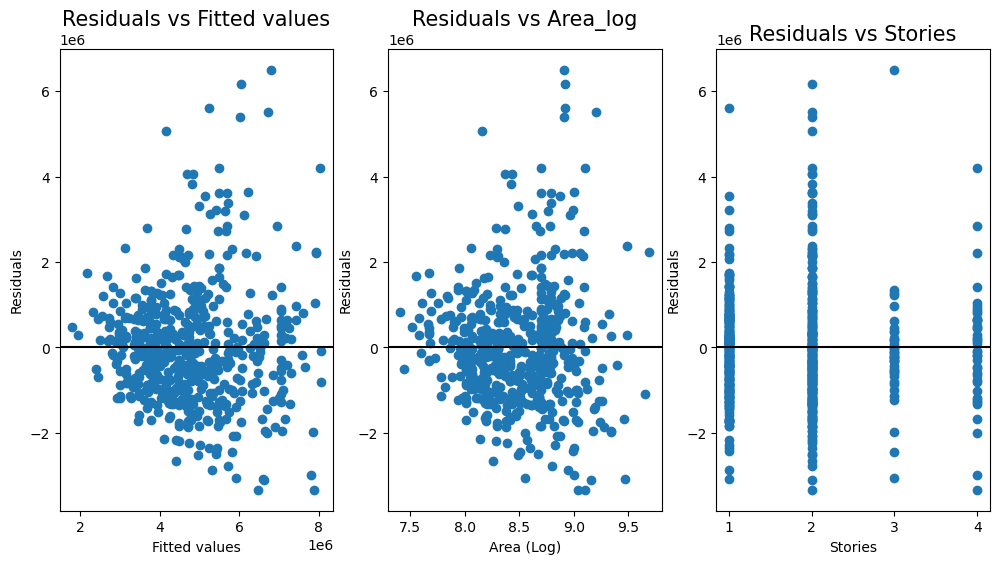

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,6))
axes = ax.flatten()
axes[0].scatter(x=predictions['mean'], y=residuals)
axes[0].set_title('Residuals vs Fitted values', fontsize=15)
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='black')


axes[1].scatter(x=df['area_log'], y=residuals)
axes[1].set_title('Residuals vs Area_log', fontsize=15)
axes[1].set_xlabel('Area (Log)')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='black')

axes[2].scatter(x=df['stories'], y=residuals)
axes[2].set_title('Residuals vs Stories', fontsize=15)
axes[2].set_xlabel('Stories')
axes[2].set_ylabel('Residuals')
axes[2].axhline(y=0, color='black')

plt.show()

Residuals improved
1. The previous issue of bias at larger houses seems to have reduced now. There is random bounce in residuals even with larger houses. The non-linearity reduced by adding Stories predictor to the model. The following two plots will help in appreciating this. Basically, when arealog>9 (where there was bias previously), stories explain the price more now (4 levels at 4 stories). Hence bias reduced.

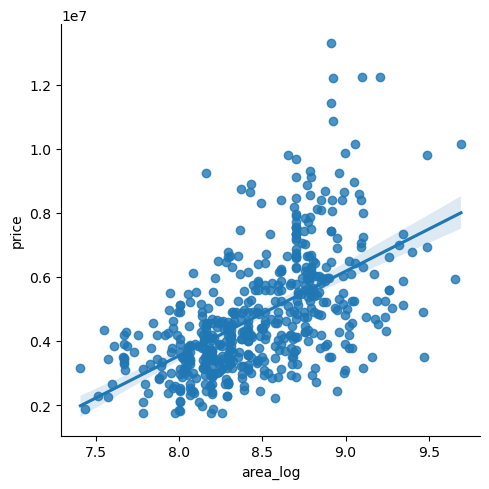

In [12]:
import seaborn as sns

sns.lmplot(x='area_log',y='price',data=df)

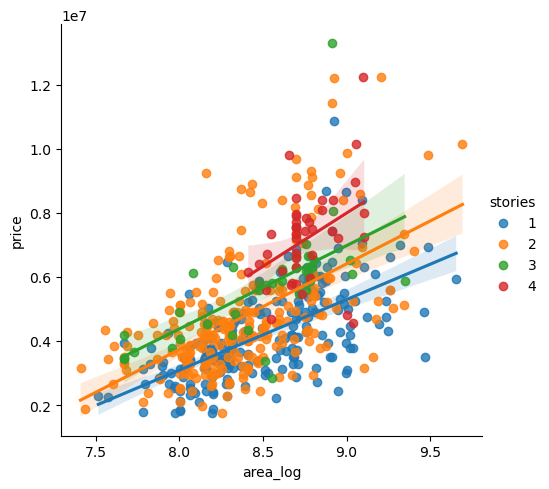

In [13]:
sns.lmplot(x='area_log',y='price',data=df, hue='stories')#, palette={0:'green',1:'blue'})

plt.show()

In [14]:
# STEP-3
predictors = ['bedrooms', 'bathrooms', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea']

coeffs = []
ts = []
ps = []
r2s = []
adj_r2s = []
aics = []

area_log_coeffs = []
area_log_ts = []
area_log_ps = []

story_coeffs = []
story_ts = []
story_ps = []

for predictor in predictors:
    Y = df['price']
    X = df[['area_log', 'stories', predictor]]
    model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

    coeff = model.params
    # Collect statistics
    t_stats = model.tvalues           # t-statistics for coefficients
    
    p_values = model.pvalues          # p values for coefficients  
    r2 = model.rsquared               # R-squared
    adj_r2 = model.rsquared_adj       # Adjusted R-squared
    aic = model.aic                   # AIC (Akaike Information Criterion)

    ts.append(t_stats.iloc[3])
    ps.append(p_values.iloc[3])
    coeffs.append(coeff.iloc[3])
    r2s.append(r2)
    adj_r2s.append(adj_r2)
    aics.append(aic)

    area_log_coeff = coeff.iloc[1]
    area_log_coeffs.append(area_log_coeff)
    area_log_t = t_stats.iloc[1]
    area_log_ts.append(area_log_t)
    area_log_p = p_values.iloc[1]
    area_log_ps.append(area_log_p)

    story_coeff = coeff.iloc[2]
    story_coeffs.append(story_coeff)
    story_t = t_stats.iloc[2]
    story_ts.append(story_t)
    story_p = p_values.iloc[2]
    story_ps.append(story_p)

step3_df = pd.DataFrame([area_log_coeffs, area_log_ts, area_log_ps,
                         story_coeffs, story_ts, story_ps,
                         predictors,coeffs, ts, ps, r2s, adj_r2s, aics]).T
step3_df.columns = ['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']
step3_df.sort_values(by = 't')

,area_log_coeff,area_log_t,area_log_p,story_coeff,story_t,story_p,predictor,Coeff,t,p,R2,AdjR2,AIC
5,2457670.138613,15.000679,0.0,781292.999568,12.166022,0.0,hotwaterheating,834523.354639,2.377839,0.017414,0.45485,0.451827,16964.42954
2,2314334.49269,13.544294,0.0,768562.617171,11.958555,0.0,mainroad,483390.258962,3.69876,0.000217,0.453291,0.45026,16965.985242
3,2325088.318088,13.848289,0.0,777534.431425,12.185578,0.0,guestroom,735798.88333,4.29459,0.000018,0.468059,0.465109,16951.061249
0,2365148.995028,14.992682,0.0,640497.000058,9.462507,0.0,bedrooms,429180.820203,4.850168,0.000001,0.469692,0.466751,16949.386127
7,2101643.904118,13.067528,0.0,782495.802422,12.726166,0.0,parking,448105.853334,5.087259,0.0,0.483185,0.480319,16935.339095
8,2237114.867996,14.143087,0.0,776008.703255,12.573215,0.0,prefarea,921895.56496,6.271289,0.0,0.487731,0.484891,16930.523888
6,2184203.209998,13.574067,0.0,644770.910745,10.125988,0.0,airconditioning,977495.746779,6.760054,0.0,0.49695,0.49416,16920.627111
4,2381448.679214,15.699465,0.0,876284.19797,13.661595,0.0,basement,921056.240771,7.227586,0.0,0.499569,0.496793,16917.782611
1,2181416.836815,14.458258,0.0,560669.374301,9.385605,0.0,bathrooms,1260506.054421,8.518967,0.0,0.545342,0.542821,16865.502973


1. `Bathrooms` explain the most variance within houses of same `area` and `story` and is statistically significant.

In [15]:
Y = df['price']
X = df[['area_log','stories', 'bathrooms']]
model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')
predictions = model.get_prediction(sm.add_constant(X)).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
residuals = Y - predictions['mean']
model.rsquared

0.5453423235679506

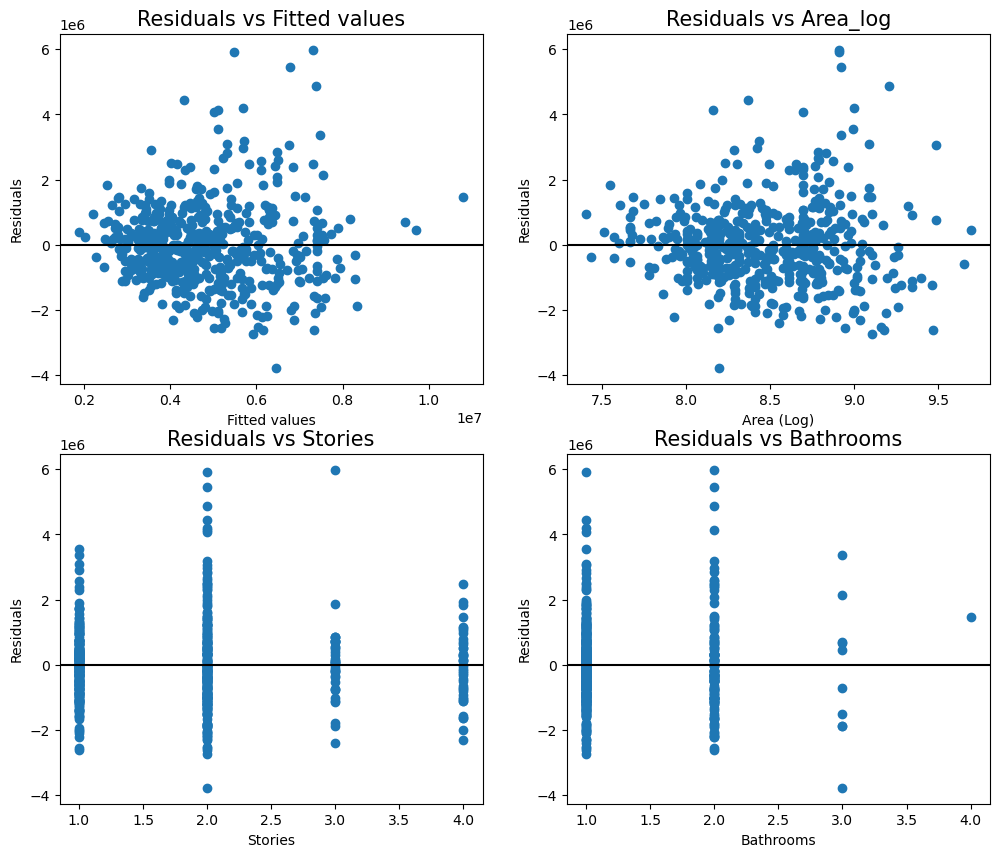

In [16]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
axes = ax.flatten()
axes[0].scatter(x=predictions['mean'], y=residuals)
axes[0].set_title('Residuals vs Fitted values', fontsize=15)
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='black')


axes[1].scatter(x=df['area_log'], y=residuals)
axes[1].set_title('Residuals vs Area_log', fontsize=15)
axes[1].set_xlabel('Area (Log)')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='black')

axes[2].scatter(x=df['stories'], y=residuals)
axes[2].set_title('Residuals vs Stories', fontsize=15)
axes[2].set_xlabel('Stories')
axes[2].set_ylabel('Residuals')
axes[2].axhline(y=0, color='black')

axes[3].scatter(x=df['bathrooms'], y=residuals)
axes[3].set_title('Residuals vs Bathrooms', fontsize=15)
axes[3].set_xlabel('Bathrooms')
axes[3].set_ylabel('Residuals')
axes[3].axhline(y=0, color='black')

plt.show()

In [17]:
# STEP-4
predictors = ['bedrooms', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea']

coeffs = []
ts = []
ps = []
r2s = []
adj_r2s = []
aics = []

area_log_coeffs = []
area_log_ts = []
area_log_ps = []

story_coeffs = []
story_ts = []
story_ps = []


bathroom_coeffs = []
bathroom_ts = []
bathroom_ps = []

for predictor in predictors:
    Y = df['price']
    X = df[['area_log', 'stories', 'bathrooms', predictor]]
    model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

    coeff = model.params
    # Collect statistics
    t_stats = model.tvalues           # t-statistics for coefficients
    
    p_values = model.pvalues          # p values for coefficients  
    r2 = model.rsquared               # R-squared
    adj_r2 = model.rsquared_adj       # Adjusted R-squared
    aic = model.aic                   # AIC (Akaike Information Criterion)

    ts.append(t_stats.iloc[4])
    ps.append(p_values.iloc[4])
    coeffs.append(coeff.iloc[4])
    r2s.append(r2)
    adj_r2s.append(adj_r2)
    aics.append(aic)

    area_log_coeff = coeff.iloc[1]
    area_log_coeffs.append(area_log_coeff)
    area_log_t = t_stats.iloc[1]
    area_log_ts.append(area_log_t)
    area_log_p = p_values.iloc[1]
    area_log_ps.append(area_log_p)

    story_coeff = coeff.iloc[2]
    story_coeffs.append(story_coeff)
    story_t = t_stats.iloc[2]
    story_ts.append(story_t)
    story_p = p_values.iloc[2]
    story_ps.append(story_p)

    bathroom_coeff = coeff.iloc[3]
    bathroom_coeffs.append(bathroom_coeff)
    bathroom_t = t_stats.iloc[3]
    bathroom_ts.append(bathroom_t)
    bathroom_p = p_values.iloc[3]
    bathroom_ps.append(bathroom_p)

step4_df = pd.DataFrame([area_log_coeffs, area_log_ts, area_log_ps,
                         story_coeffs, story_ts, story_ps,
                         bathroom_coeffs, bathroom_ts, bathroom_ps,
                         predictors,coeffs, ts, ps, r2s, adj_r2s, aics]).T
step4_df.columns = ['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'bathroom_coeff', 'bathroom_t','bathroom_p',
                    'predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']
step4_df = step4_df.sort_values(by = 't')

In [18]:
step4_df[['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'bathroom_coeff', 'bathroom_t','bathroom_p']]

,area_log_coeff,area_log_t,area_log_p,story_coeff,story_t,story_p,bathroom_coeff,bathroom_t,bathroom_p
4,2191048.373159,14.636995,0.0,560993.945011,9.3609,0.0,1240729.497519,8.465665,0.0
0,2156366.167007,14.540586,0.0,503538.81776,8.039012,0.0,1180612.918822,7.609516,0.0
2,2088415.225926,13.823129,0.0,562001.789796,9.418491,0.0,1216929.570157,8.092908,0.0
6,1911703.996228,13.09956,0.0,571529.218949,9.656871,0.0,1186106.890896,8.280283,0.0
1,2009589.141153,12.926411,0.0,535717.217661,9.02653,0.0,1284771.301036,8.902346,0.0
3,2151573.99863,15.482238,0.0,654758.510341,10.576184,0.0,1140754.404536,7.655775,0.0
5,1947234.735571,13.592647,0.0,440329.509666,7.564519,0.0,1210436.798146,8.76594,0.0
7,1974766.554455,13.694247,0.0,553419.192341,9.707431,0.0,1249415.159721,8.782518,0.0


None of the predictors lost significance

In [19]:
step4_df[['predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']]

,predictor,Coeff,t,p,R2,AdjR2,AIC
4,hotwaterheating,644815.137077,2.001908,0.045295,0.550526,0.547196,16861.253756
0,bedrooms,211353.260846,2.404248,0.016206,0.550659,0.54733,16861.092799
2,guestroom,599436.038962,3.658112,0.000254,0.55978,0.556519,16849.9155
6,parking,366678.945618,4.74576,0.000002,0.569811,0.566624,16837.353634
1,mainroad,590843.55562,4.789496,0.000002,0.55601,0.552721,16854.56349
3,basement,737430.4896,6.050994,0.0,0.578704,0.575583,16825.968958
5,airconditioning,898290.306963,7.066627,0.0,0.588106,0.585055,16813.668081
7,prefarea,902305.724786,7.067399,0.0,0.58519,0.582117,16817.513278


In [20]:
# STEP-5
predictors = ['bedrooms', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating',
       'parking', 'prefarea']

coeffs = []
ts = []
ps = []
r2s = []
adj_r2s = []
aics = []

area_log_coeffs = []
area_log_ts = []
area_log_ps = []

story_coeffs = []
story_ts = []
story_ps = []


bathroom_coeffs = []
bathroom_ts = []
bathroom_ps = []


ac_coeffs = []
ac_ts = []
ac_ps = []

for predictor in predictors:
    Y = df['price']
    X = df[['area_log', 'stories', 'bathrooms','airconditioning', predictor]]
    model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

    coeff = model.params
    # Collect statistics
    t_stats = model.tvalues           # t-statistics for coefficients
    
    p_values = model.pvalues          # p values for coefficients  
    r2 = model.rsquared               # R-squared
    adj_r2 = model.rsquared_adj       # Adjusted R-squared
    aic = model.aic                   # AIC (Akaike Information Criterion)

    ts.append(t_stats.iloc[5])
    ps.append(p_values.iloc[5])
    coeffs.append(coeff.iloc[5])
    r2s.append(r2)
    adj_r2s.append(adj_r2)
    aics.append(aic)

    area_log_coeff = coeff.iloc[1]
    area_log_coeffs.append(area_log_coeff)
    area_log_t = t_stats.iloc[1]
    area_log_ts.append(area_log_t)
    area_log_p = p_values.iloc[1]
    area_log_ps.append(area_log_p)

    story_coeff = coeff.iloc[2]
    story_coeffs.append(story_coeff)
    story_t = t_stats.iloc[2]
    story_ts.append(story_t)
    story_p = p_values.iloc[2]
    story_ps.append(story_p)

    bathroom_coeff = coeff.iloc[3]
    bathroom_coeffs.append(bathroom_coeff)
    bathroom_t = t_stats.iloc[3]
    bathroom_ts.append(bathroom_t)
    bathroom_p = p_values.iloc[3]
    bathroom_ps.append(bathroom_p)

    ac_coeff = coeff.iloc[4]
    ac_coeffs.append(ac_coeff)
    ac_t = t_stats.iloc[4]
    ac_ts.append(ac_t)
    ac_p = p_values.iloc[4]
    ac_ps.append(ac_p)

step5_df = pd.DataFrame([area_log_coeffs, area_log_ts, area_log_ps,
                         story_coeffs, story_ts, story_ps,
                         bathroom_coeffs, bathroom_ts, bathroom_ps,
                         ac_coeffs, ac_ts, ac_ps,
                         predictors,coeffs, ts, ps, r2s, adj_r2s, aics]).T
step5_df.columns = ['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'bathroom_coeff', 'bathroom_t','bathroom_p',
                    'ac_coeff', 'ac_t', 'ac_p',
                    'predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']
step5_df = step5_df.sort_values(by = 't')

In [21]:
step5_df[['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'bathroom_coeff', 'bathroom_t','bathroom_p',
                    'ac_coeff', 'ac_t', 'ac_p']]

,area_log_coeff,area_log_t,area_log_p,story_coeff,story_t,story_p,bathroom_coeff,bathroom_t,bathroom_p,ac_coeff,ac_t,ac_p
0,1922644.239313,13.535089,0.0,383812.958113,6.236237,0.0,1131277.879126,7.808789,0.0,897344.835065,7.084197,0.0
4,1943813.164865,13.652952,0.0,431848.428811,7.420909,0.0,1177963.771176,8.77146,0.0,965120.154493,7.630073,0.0
2,1877860.223952,12.894502,0.0,446714.921586,7.736254,0.0,1175330.61265,8.377937,0.0,859136.486721,6.943069,0.0
5,1710696.693143,11.933346,0.0,455792.906483,7.782034,0.0,1144523.800562,8.485141,0.0,857177.034603,6.763141,0.0
1,1774581.874375,11.927056,0.0,415180.190363,7.254175,0.0,1234744.098086,9.200283,0.0,899094.978155,7.16067,0.0
3,1935685.311587,14.42847,0.0,534216.559739,8.845687,0.0,1104545.275736,7.868183,0.0,838164.894347,6.764286,0.0
6,1765173.013781,12.981357,0.0,439975.473644,7.970891,0.0,1202683.514401,8.929659,0.0,849952.548809,6.975449,0.0


In [22]:
step5_df[['predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']]

,predictor,Coeff,t,p,R2,AdjR2,AIC
0,bedrooms,209550.340682,2.546998,0.010865,0.593332,0.58956,16808.709153
4,hotwaterheating,937330.531046,2.858456,0.004257,0.598823,0.595101,16801.300731
2,guestroom,512939.603675,3.414755,0.000638,0.598597,0.594873,16801.607583
5,parking,336148.744335,4.513566,0.000006,0.60858,0.604949,16787.881233
1,mainroad,592959.623358,5.024471,0.000001,0.59885,0.595129,16801.26347
3,basement,672717.106489,5.71254,0.0,0.615678,0.612113,16777.907959
6,prefarea,849966.281374,7.07776,0.0,0.623341,0.619847,16766.930854


In [23]:
# STEP-6
predictors = ['bedrooms', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating',
       'parking']

coeffs = []
ts = []
ps = []
r2s = []
adj_r2s = []
aics = []

area_log_coeffs = []
area_log_ts = []
area_log_ps = []

story_coeffs = []
story_ts = []
story_ps = []


bathroom_coeffs = []
bathroom_ts = []
bathroom_ps = []


ac_coeffs = []
ac_ts = []
ac_ps = []

prefarea_coeffs = []
prefarea_ts = []
prefarea_ps = []

for predictor in predictors:
    Y = df['price']
    X = df[['area_log', 'stories', 'bathrooms','airconditioning','prefarea', predictor]]
    model = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

    coeff = model.params
    # Collect statistics
    t_stats = model.tvalues           # t-statistics for coefficients
    
    p_values = model.pvalues          # p values for coefficients  
    r2 = model.rsquared               # R-squared
    adj_r2 = model.rsquared_adj       # Adjusted R-squared
    aic = model.aic                   # AIC (Akaike Information Criterion)

    ts.append(t_stats.iloc[6])
    ps.append(p_values.iloc[6])
    coeffs.append(coeff.iloc[6])
    r2s.append(r2)
    adj_r2s.append(adj_r2)
    aics.append(aic)

    area_log_coeff = coeff.iloc[1]
    area_log_coeffs.append(area_log_coeff)
    area_log_t = t_stats.iloc[1]
    area_log_ts.append(area_log_t)
    area_log_p = p_values.iloc[1]
    area_log_ps.append(area_log_p)

    story_coeff = coeff.iloc[2]
    story_coeffs.append(story_coeff)
    story_t = t_stats.iloc[2]
    story_ts.append(story_t)
    story_p = p_values.iloc[2]
    story_ps.append(story_p)

    bathroom_coeff = coeff.iloc[3]
    bathroom_coeffs.append(bathroom_coeff)
    bathroom_t = t_stats.iloc[3]
    bathroom_ts.append(bathroom_t)
    bathroom_p = p_values.iloc[3]
    bathroom_ps.append(bathroom_p)

    ac_coeff = coeff.iloc[4]
    ac_coeffs.append(ac_coeff)
    ac_t = t_stats.iloc[4]
    ac_ts.append(ac_t)
    ac_p = p_values.iloc[4]
    ac_ps.append(ac_p)

    prefarea_coeff = coeff.iloc[5]
    prefarea_coeffs.append(prefarea_coeff)
    prefarea_t = t_stats.iloc[5]
    prefarea_ts.append(prefarea_t)
    prefarea_p = p_values.iloc[5]
    prefarea_ps.append(prefarea_p)

step6_df = pd.DataFrame([area_log_coeffs, area_log_ts, area_log_ps,
                         story_coeffs, story_ts, story_ps,
                         bathroom_coeffs, bathroom_ts, bathroom_ps,
                         ac_coeffs, ac_ts, ac_ps,
                         prefarea_coeffs, prefarea_ts, prefarea_ps,
                         predictors,coeffs, ts, ps, r2s, adj_r2s, aics]).T
step6_df.columns = ['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'bathroom_coeff', 'bathroom_t','bathroom_p',
                    'ac_coeff', 'ac_t', 'ac_p',
                    'prefarea_coeff', 'prefarea_t', 'prefarea_p',
                    'predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']
step6_df = step6_df.sort_values(by = 't')

In [24]:
step6_df[ ['area_log_coeff','area_log_t','area_log_p',
                    'story_coeff', 'story_t','story_p',
                    'bathroom_coeff', 'bathroom_t','bathroom_p',
                    'ac_coeff', 'ac_t', 'ac_p',
                    'prefarea_coeff', 'prefarea_t', 'prefarea_p']]

,area_log_coeff,area_log_t,area_log_p,story_coeff,story_t,story_p,bathroom_coeff,bathroom_t,bathroom_p,ac_coeff,ac_t,ac_p,prefarea_coeff,prefarea_t,prefarea_p
0,1745663.66553,12.95324,0.0,389307.339084,6.651136,0.0,1131817.274273,8.014201,0.0,849778.845863,6.998073,0.0,838114.509869,6.978894,0.0
2,1719824.754927,12.589771,0.0,445040.176431,8.149292,0.0,1175343.335404,8.623149,0.0,821526.205235,6.928036,0.0,805721.665613,6.410765,0.0
4,1755776.223474,12.968467,0.0,430669.7419,7.802601,0.0,1166854.563156,8.968525,0.0,921694.733811,7.55418,0.0,876329.44143,7.292452,0.0
1,1643787.933423,11.661225,0.0,420768.781863,7.71964,0.0,1221719.048143,9.272462,0.0,853385.425025,7.067959,0.0,800420.417739,6.494905,0.0
3,1784978.370845,13.506519,0.0,513469.656399,8.749608,0.0,1121083.708424,8.095408,0.0,810579.560145,6.726113,0.0,715328.368854,5.552339,0.0
5,1532206.46865,11.19488,0.0,455279.460102,8.291018,0.0,1137505.985102,8.659275,0.0,809560.935578,6.671987,0.0,844829.350706,7.224593,0.0


In [25]:
step6_df[['predictor', 'Coeff', 't', 'p', 'R2', 'AdjR2', 'AIC']]

,predictor,Coeff,t,p,R2,AdjR2,AIC
0,bedrooms,187884.062912,2.335335,0.019526,0.627536,0.623382,16762.827991
2,guestroom,405366.734802,2.647582,0.008107,0.629798,0.625669,16759.507937
4,hotwaterheating,1027257.464857,3.067483,0.002159,0.636179,0.632121,16750.031882
1,mainroad,453333.534812,3.641783,0.000271,0.629502,0.62537,16759.943877
3,basement,526196.823827,4.248254,0.000022,0.639327,0.635304,16745.296296
5,parking,332636.912853,4.623844,0.000004,0.643389,0.639412,16739.123422


In [92]:
# Final Model after more steps
df_dummies = pd.get_dummies(df['furnishingstatus'], drop_first=True)
df_dummies.columns=['semifurnished','furnished']
df['semifurished'] = df_dummies['semifurnished'].astype(int)
df['furnished'] = df_dummies['furnished'].astype(int)

Y = df['price']/1000000 #Millions
Y = np.log(df['price'])
X = df[['area_log', 'stories', 'bathrooms','airconditioning','prefarea', 'parking','basement', 'hotwaterheating','mainroad','semifurished','furnished']]
#X = df[['area_log']]
model_OLS = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC1')

predictions_OLS = model_OLS.get_prediction(sm.add_constant(X)).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
residuals_OLS = Y - predictions_OLS['mean']

model_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     127.3
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          3.03e-141
Time:                        10:55:23   Log-Likelihood:                 97.409
No. Observations:                 545   AIC:                            -170.8
Df Residuals:                     533   BIC:                            -119.2
Df Model:                          11                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.9740      0.210     57.003      0.000      11.562      12.386
area_log            0.3081      0.026     11.808      0.000       0.257       0.359
stories             0.1001      0.011      9.180      0.000       0.079       0.122
bathrooms           0.1719      0.021      8.251      0.000       0.131       0.213
airconditioning     0.1650      0.021      7.958      0.000       0.124       0.206
prefarea            0.1339      0.021      6.404      0.000       0.093       0.175
parking             0.0421      0.011      3.675      0.000       0.020       0.065
basement            0.1158      0.022      5.355      0.000       0.073       0.158
hotwaterheating     0.1660      0.052      3.211      0.001       0.065       0.267
mainroad            0.0906      0.027      3.349      0.001       0.038       0.144
semifurished        0.1289      0.021      6.060      0.000       0.087       0.171
furnished           0.1180      0.025      4.759      0.000       0.069       0.167
==============================================================================
Omnibus:                        3.658   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                4.312
Skew:                          -0.015   Prob(JB):                        0.116
Kurtosis:                       3.435   Cond. No.                         213.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [93]:
print(residuals_OLS.std())

0.2025534316183926


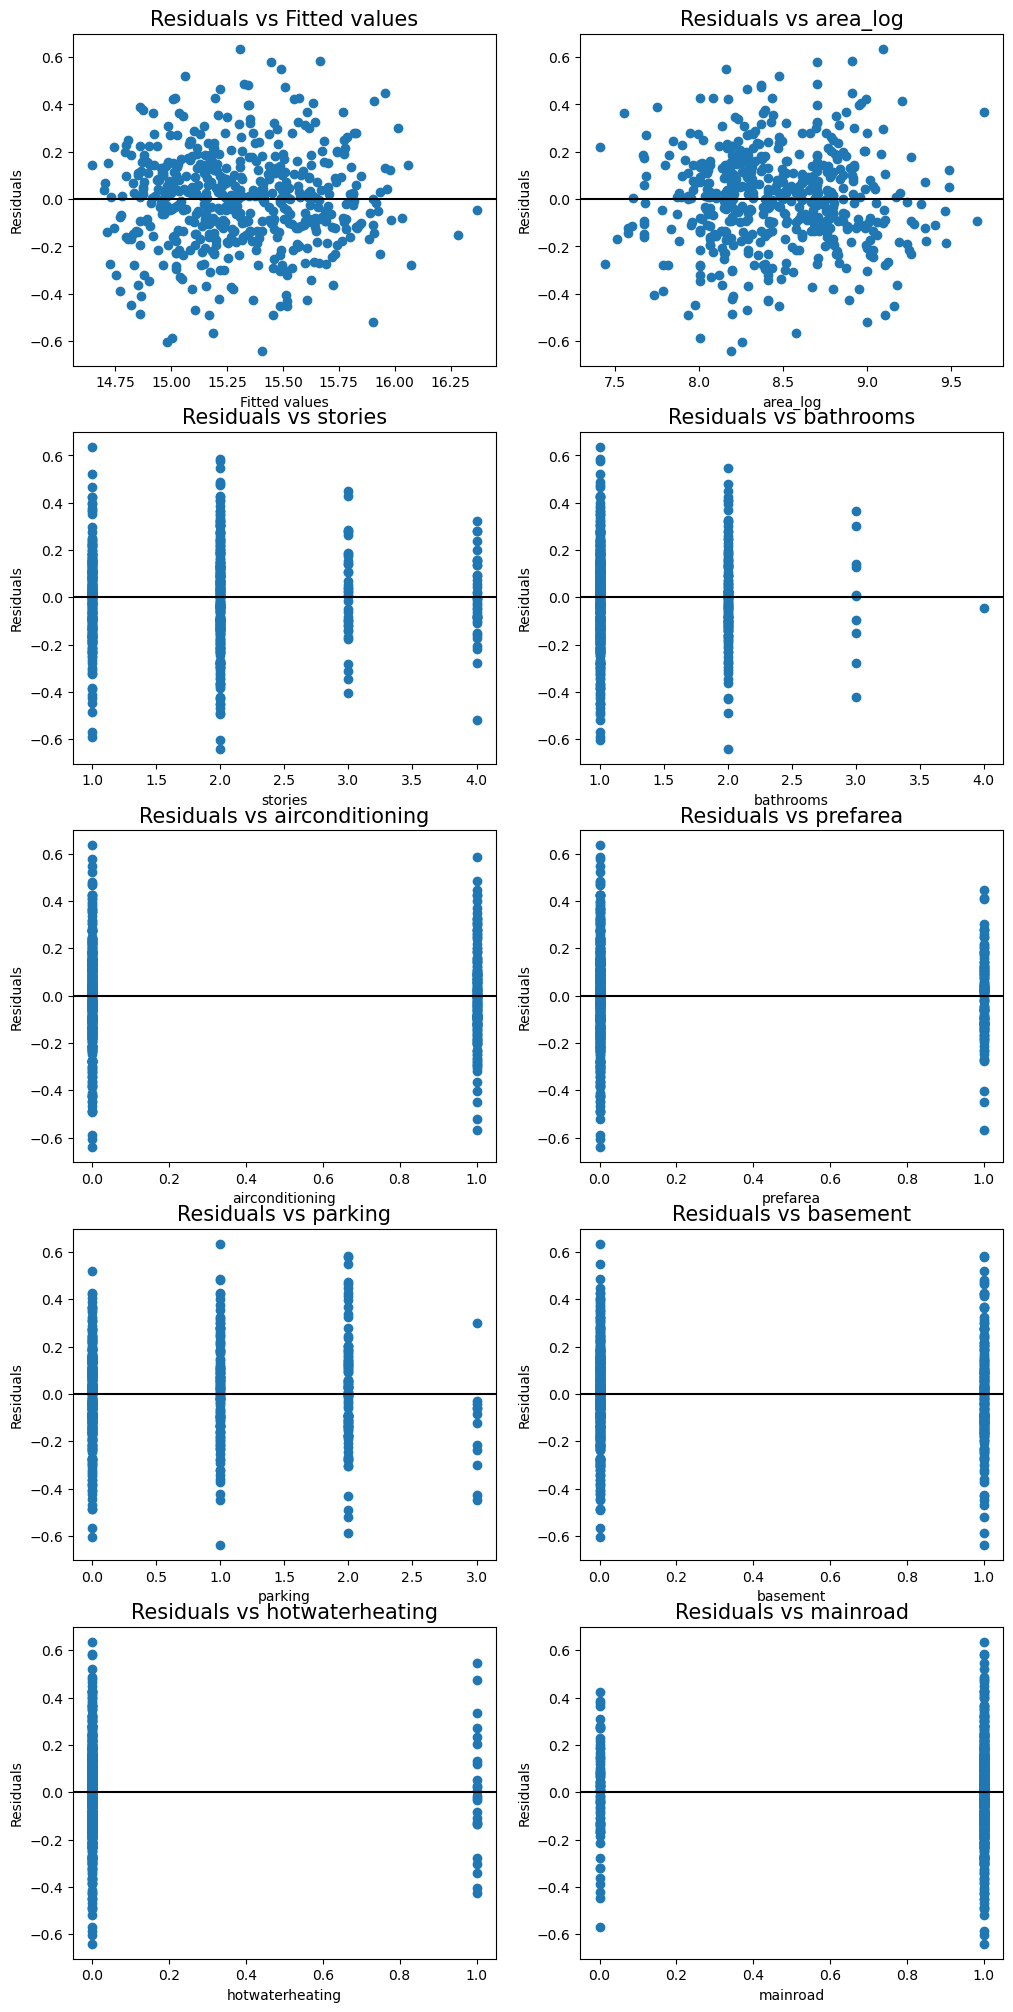

In [94]:
fig, ax = plt.subplots(5,2, figsize=(12,25))
axes = ax.flatten()
axes[0].scatter(x=predictions_OLS['mean'], y=residuals_OLS)
axes[0].set_title('Residuals vs Fitted values', fontsize=15)
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='black')

for idx, predictor in enumerate(['area_log', 'stories', 'bathrooms','airconditioning','prefarea', 'parking','basement', 'hotwaterheating','mainroad']):
    axes[idx+1].scatter(x=df[predictor], y=residuals_OLS)
    axes[idx+1].set_title('Residuals vs {}'.format(predictor), fontsize=15)
    axes[idx+1].set_xlabel('{}'.format(predictor))
    axes[idx+1].set_ylabel('Residuals')
    axes[idx+1].axhline(y=0, color='black')

plt.show()

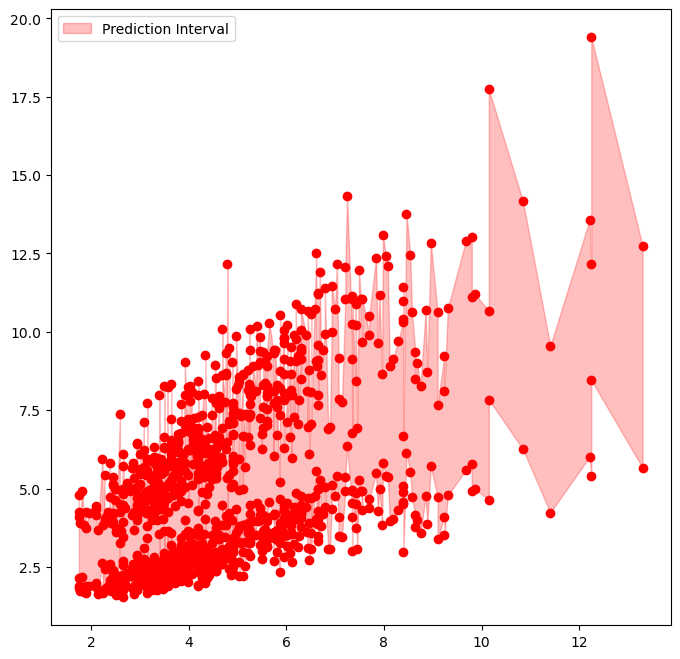

In [95]:
predictions_OLS
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot lines
ax.scatter(df['price']/1000000, np.exp(predictions_OLS['obs_ci_lower'])/1000000, color="red", )
ax.scatter(df['price']/1000000, np.exp(predictions_OLS['obs_ci_upper'])/1000000, color="red", )
#ax.scatter(df['price']/1000000, predictions_OLS['obs_ci_lower'], color="red", )
#ax.scatter(df['price']/1000000, predictions_OLS['obs_ci_upper'], color="red", )

# Fill area when income <= df['expenses'] with red
ax.fill_between(
    df['price']/1000000, np.exp(predictions_OLS['obs_ci_lower'])/1000000, np.exp(predictions_OLS['obs_ci_upper'])/1000000,
    where=(np.exp(predictions_OLS['obs_ci_lower'])/1000000 <= np.exp(predictions_OLS['obs_ci_upper'])/1000000), 
    interpolate=True, color="red", alpha=0.25,
    label="Prediction Interval"
)

# ax.fill_between(
#     df['price']/1000000, predictions_OLS['obs_ci_lower'], predictions_OLS['obs_ci_upper'],
#     where=(predictions_OLS['obs_ci_lower'] <= predictions_OLS['obs_ci_upper']), 
#     interpolate=True, color="red", alpha=0.25,
#     label="Prediction Interval"
# )

ax.legend()
plt.show()


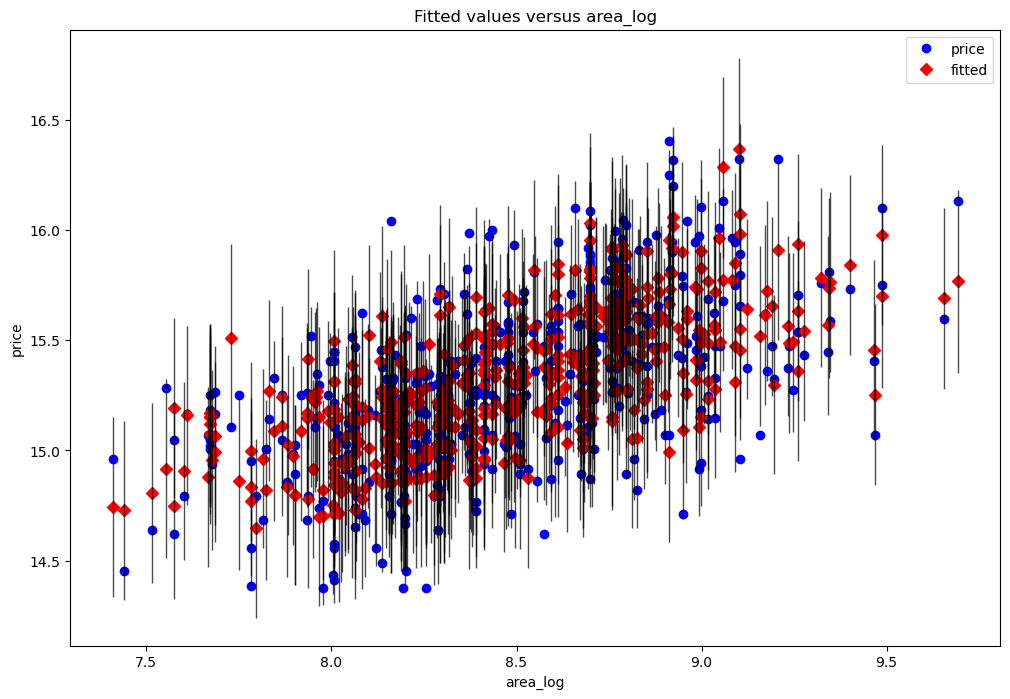

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(model_OLS, 1, ax=ax)
plt.show()

In [30]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

kfold_validation = KFold(10, shuffle=True)
model = LinearRegression()

results = cross_val_score(model, sm.add_constant(np.array(X)), np.array(Y), scoring='neg_root_mean_squared_error', cv=kfold_validation)
results

array([-1.03241827, -0.99754556, -0.92769754, -1.05401111, -0.96260409,
       -1.06894752, -1.21916779, -1.03074783, -1.27725481, -1.23006211])

In [31]:
np.mean(results)

-1.0800456625975556

Mean Squared Error: 1.35
R² Score: 0.65


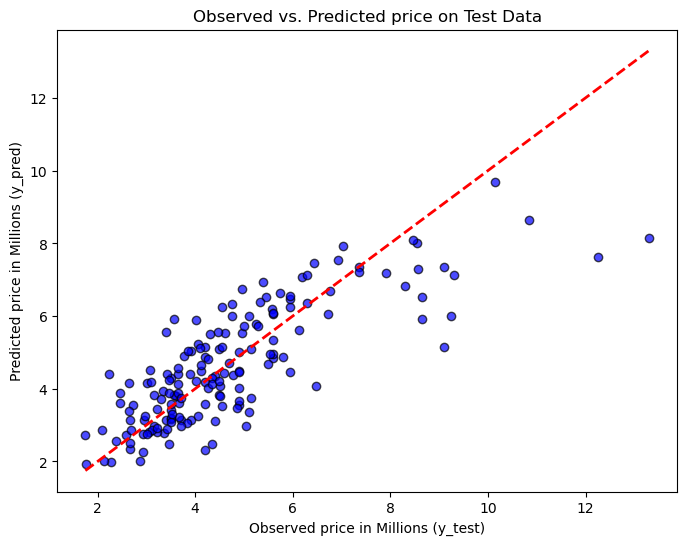

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=111)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Observed vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', lw=2)  # Ideal line
plt.xlabel("Observed price in Millions (y_test)")
plt.ylabel("Predicted price in Millions (y_pred)")
plt.title("Observed vs. Predicted price on Test Data")
plt.show()

In [33]:
(y_pred - y_test).std()

1.1647903208166406

In [34]:
X_new = pd.DataFrame([1,
                      7.5,#X['area_log'].sample(1).to_list()[0],
         X['stories'].sample(1).to_list()[0],
         X['bathrooms'].sample(2).to_list()[0],
         X['airconditioning'].sample(1).to_list()[0],
          X['prefarea'].sample(1).to_list()[0],
          X['parking'].sample(1).to_list()[0],
          X['basement'].sample(1).to_list()[0],
         X['hotwaterheating'].sample(1).to_list()[0],
         X['mainroad'].sample(1).to_list()[0],
     X['semifurished'].sample(1).to_list()[0],
     X['furnished'].sample(1).to_list()[0],
        ]).T
#X_new.columns = X.columns
X_new

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,7.5,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:

predictions = model_OLS.get_prediction(X_new).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.188459,0.144392,1.905455,2.471462,0.081169,4.295748


In [36]:
predictions = model_OLS.get_prediction([1,7.5,4,1,1,1,1,1,0,1,1,0]).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,5.722879,0.257504,5.21818,6.227578,3.574555,7.871204


In [37]:
X_test.reset_index()[X_test.reset_index()['index']==0]#.loc[:,:]

,index,area_log,stories,bathrooms,airconditioning,prefarea,parking,basement,hotwaterheating,mainroad,semifurished,furnished
82,0,8.911934,3,2,1,1,2,0,0,1,0,1


In [38]:
X.area_log.sort_values()

449    7.408531
537    7.438384
527    7.515345
271    7.552237
413    7.575585
         ...   
403    9.468388
10     9.487972
66     9.487972
125    9.655026
7      9.692767
Name: area_log, Length: 545, dtype: float64

In [39]:
y_test.sort_values()

542     1.75000
541     1.76715
535     2.10000
532     2.13500
531     2.23300
         ...   
12      9.31000
6      10.15000
5      10.85000
2      12.25000
0      13.30000
Name: price, Length: 164, dtype: float64

In [40]:
results.mean()

-1.0800456625975556

In [41]:
residuals.std()

1261205.7911823285

# WLS

In [42]:
(Y - Y.mean())/Y.std()


0      4.562174
1      4.000809
2      4.000809
3      3.982096
4      3.551716
         ...   
540   -1.575421
541   -1.603676
542   -1.612845
543   -1.612845
544   -1.612845
Name: price, Length: 545, dtype: float64

In [136]:
# Final Model after more steps
df_dummies = pd.get_dummies(df['furnishingstatus'], drop_first=True)
df_dummies.columns=['semifurnished','furnished']
df['semifurished'] = df_dummies['semifurnished'].astype(int)
df['furnished'] = df_dummies['furnished'].astype(int)

Y = df['price']/1000000 #Millions
X = df[['area_log', 'stories', 'bathrooms','airconditioning','prefarea', 'parking','basement', 'hotwaterheating','mainroad','semifurished','furnished']]

# Calculate weights based on the inverse of the variance of the errors
K = abs(residuals_OLS)
model_temp = sm.OLS(K,  sm.add_constant(X)).fit()
weight_3 = model_temp.fittedvalues
weight_3 = weight_3**-1
weight_3 = df.area_log
weight_3 = weight_3**-2

model_WLS = sm.WLS(Y, sm.add_constant(X), weights=weight_3).fit()

predictions_WLS = model_WLS.get_prediction(sm.add_constant(X), weights=weight_3).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
residuals_WLS = Y - predictions_WLS['mean']

model_WLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            WLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     104.1
Date:                Sat, 02 Nov 2024   Prob (F-statistic):          5.19e-125
Time:                        12:36:08   Log-Likelihood:                -791.51
No. Observations:                 545   AIC:                             1607.
Df Residuals:                     533   BIC:                             1659.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -11.1759      1.062    -10.519      0.000     -13.263      -9.089
area_log            1.4729      0.132     11.184      0.000       1.214       1.732
stories             0.4915      0.059      8.285      0.000       0.375       0.608
bathrooms           0.9875      0.100      9.915      0.000       0.792       1.183
airconditioning     0.8075      0.107      7.526      0.000       0.597       1.018
prefarea            0.6772      0.113      5.975      0.000       0.455       0.900
parking             0.2682      0.058      4.645      0.000       0.155       0.382
basement            0.4536      0.100      4.541      0.000       0.257       0.650
hotwaterheating     0.8444      0.217      3.889      0.000       0.418       1.271
mainroad            0.2832      0.136      2.089      0.037       0.017       0.550
semifurished        0.3785      0.106      3.567      0.000       0.170       0.587
furnished           0.4528      0.123      3.681      0.000       0.211       0.695
==============================================================================
Omnibus:                       93.299   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.208
Skew:                           0.891   Prob(JB):                     9.23e-49
Kurtosis:                       5.562   Cond. No.                         213.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

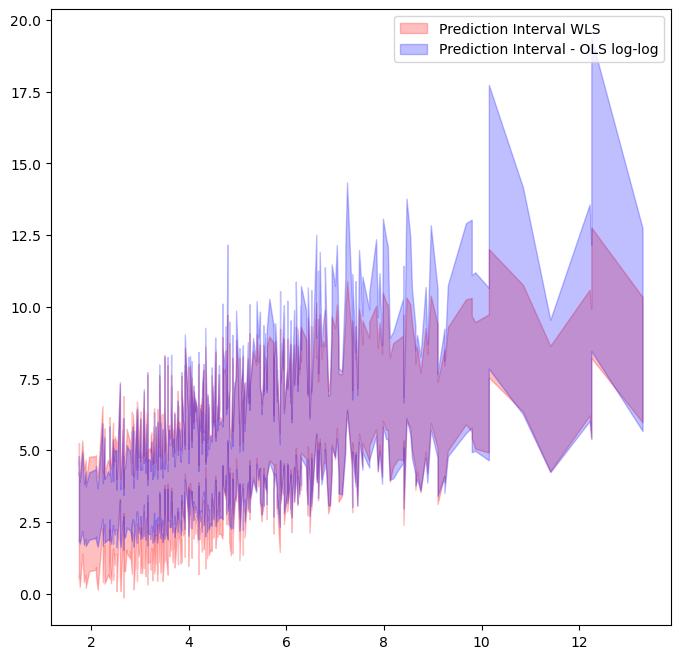

In [137]:
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot lines
#ax.scatter(df['price']/1000000, predictions_WLS['obs_ci_lower'], color="red", )
#ax.scatter(df['price']/1000000, predictions_WLS['obs_ci_upper'], color="red", )

# Fill area when income <= df['expenses'] with red

ax.fill_between(
    df['price']/1000000, predictions_WLS['obs_ci_lower'], predictions_WLS['obs_ci_upper'],
    where=(predictions_WLS['obs_ci_lower'] <= predictions_WLS['obs_ci_upper']), 
    interpolate=True, color="red", alpha=0.25,
    label="Prediction Interval WLS"
)

# Plot lines
#ax.scatter(df['price']/1000000, np.exp(predictions_OLS['obs_ci_lower'])/1000000, color="blue", )
#ax.scatter(df['price']/1000000, np.exp(predictions_OLS['obs_ci_upper'])/1000000, color="blue", )

# Fill area when income <= df['expenses'] with red
ax.fill_between(
    df['price']/1000000, np.exp(predictions_OLS['obs_ci_lower'])/1000000, np.exp(predictions_OLS['obs_ci_upper'])/1000000,
    where=(np.exp(predictions_OLS['obs_ci_lower'])/1000000 <= np.exp(predictions_OLS['obs_ci_upper'])/1000000), 
    interpolate=True, color="blue", alpha=0.25,
    label="Prediction Interval - OLS log-log"
)

ax.legend()
plt.show()

In [110]:
rss = (weight_3*(Y-model_WLS.fittedvalues)**2).sum()

weighted_mean_Y = np.sum(weight_3 * Y) / np.sum(weight_3)
tss = (weight_3*(Y-weighted_mean_Y)**2).sum()

r2 = 1 - (rss/tss) 
r2

0.6824256067551353

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)#, random_state=42)

Mean Squared Error: 1.30
R² Score: 0.64


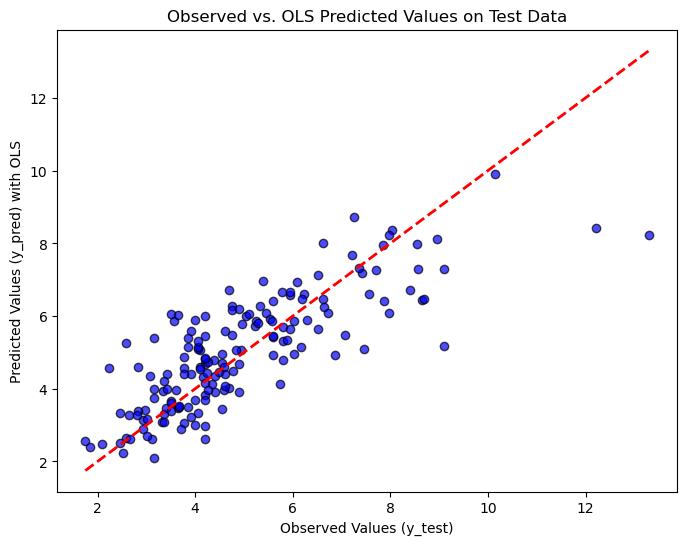

In [112]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Observed vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', lw=2)  # Ideal line
plt.xlabel("Observed Values (y_test)")
plt.ylabel("Predicted Values (y_pred) with OLS")
plt.title("Observed vs. OLS Predicted Values on Test Data")
plt.show()

Mean Squared Error: 1.47
R² Score: 0.60


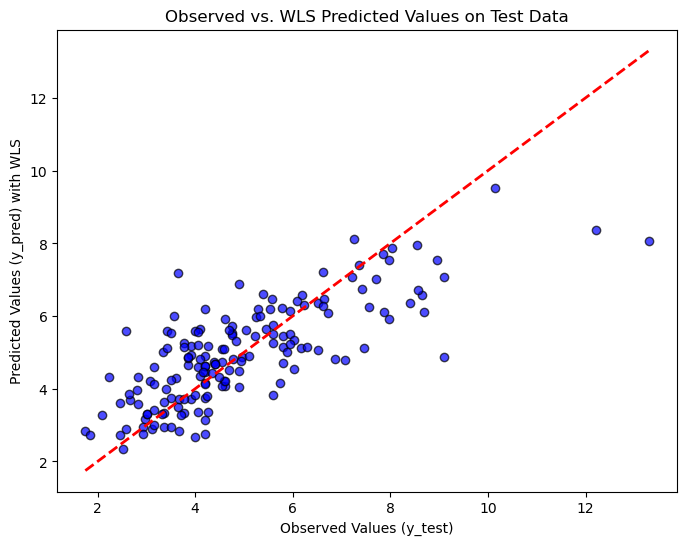

In [135]:
w_train = (y_train - y_train.median())/y_train.std()
w_train = abs(w_train)
w_train= X_train.area_log**-2
# Initialize and train the WLS linear regression model
model = sm.WLS(y_train, X_train, weights=w_train).fit()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Observed vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', lw=2)  # Ideal line
plt.xlabel("Observed Values (y_test)")
plt.ylabel("Predicted Values (y_pred) with WLS")
plt.title("Observed vs. WLS Predicted Values on Test Data")
plt.show()

# WLS minimises weighted residuals 

In [114]:
(y_pred - y_test).std()

1.2930565941688612

# Decisition Tree

Mean Squared Error: 3.17
R² Score: 0.29


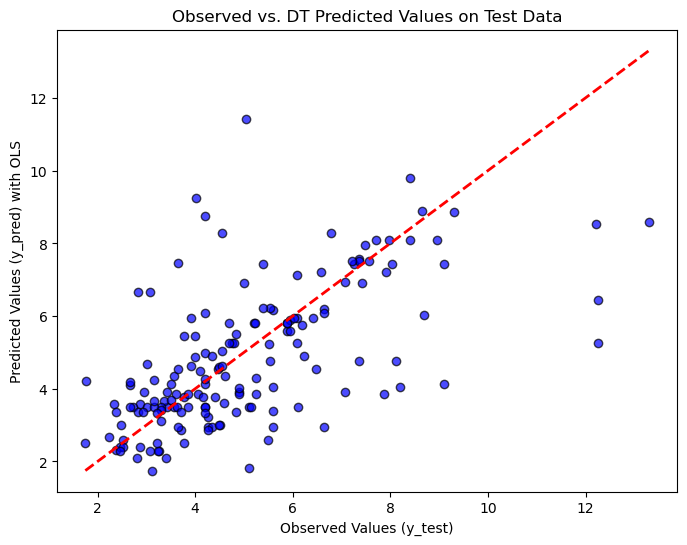

In [49]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0)  

regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Observed vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', lw=2)  # Ideal line
plt.xlabel("Observed Values (y_test)")
plt.ylabel("Predicted Values (y_pred) with OLS")
plt.title("Observed vs. DT Predicted Values on Test Data")
plt.show()

In [50]:
(y_pred - y_test).std()

1.7743393223404347

In [51]:
rss = ((y_test - y_pred)**2).sum()
tss = ((y_test - y_test.mean())**2).sum()
1 - rss/tss

0.29346185742051734

In [52]:
1 - ((weight_3*residuals_WLS).std()**2/(weight_3*Y.std())**2)

0      0.990241
1      0.983499
2      0.983499
3      0.983187
4      0.973433
         ...   
540    0.313713
541    0.360817
542    0.375229
543    0.375229
544    0.375229
Name: price, Length: 545, dtype: float64

In [53]:
predictions = model_WLS.get_prediction([1,6,2,1,1,1,1,1,0,1,1,0]).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1.56299,0.567766,0.447655,2.678324,-1.503581,4.62956


In [54]:
predictions = model_OLS.get_prediction([1,6,2,1,1,1,1,1,0,1,1,0]).summary_frame(alpha=0.05)  # alpha = significance level for confidence interval
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.571184,0.387498,1.811703,3.330666,0.349161,4.793208


In [55]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [56]:
X.columns

Index(['area_log', 'stories', 'bathrooms', 'airconditioning', 'prefarea',
       'parking', 'basement', 'hotwaterheating', 'mainroad', 'semifurished',
       'furnished'],
      dtype='object')

In [57]:
pd.DataFrame([1])
X_new = pd.DataFrame([1,
                      X['area_log'].sample(1).to_list()[0],
         X['stories'].sample(1).to_list()[0],
         X['bathrooms'].sample(1).to_list()[0],
         X['airconditioning'].sample(1).to_list()[0],
          X['prefarea'].sample(1).to_list()[0],
          X['parking'].sample(1).to_list()[0],
          X['basement'].sample(1).to_list()[0],
         X['hotwaterheating'].sample(1).to_list()[0],
         X['mainroad'].sample(1).to_list()[0],
     X['semifurished'].sample(1).to_list()[0],
     X['furnished'].sample(1).to_list()[0],
        ]).T

X_new.columns = ['const','area_log', 'stories', 'bathrooms', 'airconditioning', 'prefarea',
       'parking', 'basement', 'hotwaterheating', 'mainroad', 'semifurished',
       'furnished']
X_new

,const,area_log,stories,bathrooms,airconditioning,prefarea,parking,basement,hotwaterheating,mainroad,semifurished,furnished
0,1.0,8.856518,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [58]:
prstd, iv_l, iv_u = wls_prediction_std(res = model_WLS)
prstd

array([3.53803979e-01, 4.38714554e-01, 4.15319638e-01, 4.04536446e-01,
       4.49117606e-01, 5.04963015e-01, 5.41941550e-01, 5.90946198e-01,
       5.59447415e-01, 5.80452424e-01, 5.78975246e-01, 6.24240032e-01,
       6.27196521e-01, 6.73787162e-01, 6.43136820e-01, 6.62350284e-01,
       6.58016745e-01, 6.69958824e-01, 6.82690060e-01, 6.91146954e-01,
       7.40129177e-01, 7.31231763e-01, 7.32378910e-01, 7.28452808e-01,
       7.34421405e-01, 7.36628048e-01, 7.81649156e-01, 7.80310695e-01,
       8.06147981e-01, 7.70125734e-01, 7.75829218e-01, 7.87447187e-01,
       7.93421574e-01, 8.31716345e-01, 8.33123035e-01, 8.36466511e-01,
       8.91407709e-01, 8.63553720e-01, 8.84400723e-01, 8.86775011e-01,
       9.01099259e-01, 9.12391946e-01, 9.49056889e-01, 9.55293454e-01,
       9.88473682e-01, 9.94978143e-01, 1.00064734e+00, 1.03097852e+00,
       1.03138259e+00, 1.05151349e+00, 1.05498052e+00, 1.04884471e+00,
       1.06653626e+00, 1.07265010e+00, 1.06941823e+00, 1.06924381e+00,
      

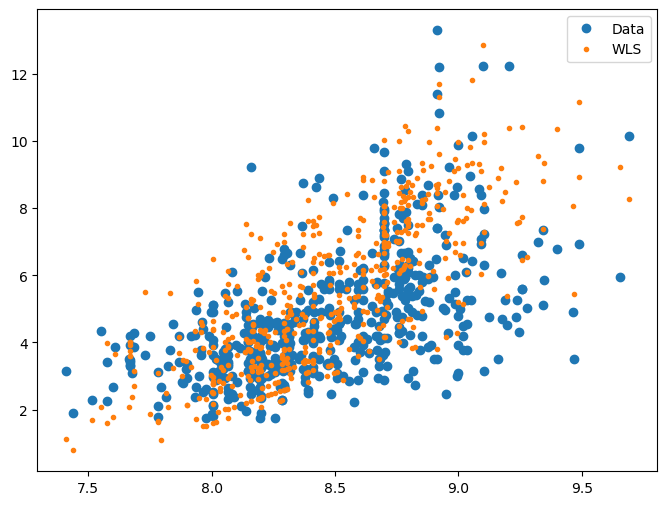

In [59]:
fig, ax = plt.subplots(figsize=(8,6))

x = X['area_log']
y = Y

ax.plot(x, y, 'o', label="Data")
#ax.plot(x, y_true, 'b-', label="True")
# OLS
#ax.plot(x, res_ols.fittedvalues, 'r--')
#ax.plot(x, iv_u_ols, 'r--', label="OLS")
#ax.plot(x, iv_l_ols, 'r--')
# WLS
#ax.plot(x, model_WLS.fittedvalues, 'g--.')
ax.plot(x, model_WLS.fittedvalues, '.', label="WLS")
#ax.plot(x, iv_l, '.')
ax.legend(loc="best");


In [60]:
model_WLS.fittedvalues

0      10.374898
1      12.874975
2      10.385691
3      11.713617
4       8.599757
         ...    
540     4.400972
541     1.653752
542     2.336698
543     2.315849
544     2.778525
Length: 545, dtype: float64

In [61]:
prstd

array([3.53803979e-01, 4.38714554e-01, 4.15319638e-01, 4.04536446e-01,
       4.49117606e-01, 5.04963015e-01, 5.41941550e-01, 5.90946198e-01,
       5.59447415e-01, 5.80452424e-01, 5.78975246e-01, 6.24240032e-01,
       6.27196521e-01, 6.73787162e-01, 6.43136820e-01, 6.62350284e-01,
       6.58016745e-01, 6.69958824e-01, 6.82690060e-01, 6.91146954e-01,
       7.40129177e-01, 7.31231763e-01, 7.32378910e-01, 7.28452808e-01,
       7.34421405e-01, 7.36628048e-01, 7.81649156e-01, 7.80310695e-01,
       8.06147981e-01, 7.70125734e-01, 7.75829218e-01, 7.87447187e-01,
       7.93421574e-01, 8.31716345e-01, 8.33123035e-01, 8.36466511e-01,
       8.91407709e-01, 8.63553720e-01, 8.84400723e-01, 8.86775011e-01,
       9.01099259e-01, 9.12391946e-01, 9.49056889e-01, 9.55293454e-01,
       9.88473682e-01, 9.94978143e-01, 1.00064734e+00, 1.03097852e+00,
       1.03138259e+00, 1.05151349e+00, 1.05498052e+00, 1.04884471e+00,
       1.06653626e+00, 1.07265010e+00, 1.06941823e+00, 1.06924381e+00,
      

In [62]:
X

,area_log,stories,bathrooms,airconditioning,prefarea,parking,basement,hotwaterheating,mainroad,semifurished,furnished
0,8.911934,3,2,1,1,2,0,0,1,0,1
1,9.100526,4,4,1,0,3,0,0,1,0,1
2,9.206332,2,2,0,1,2,1,0,1,1,0
3,8.922658,2,2,1,1,3,1,0,1,0,1
4,8.911934,2,1,1,0,2,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
540,8.006368,1,1,0,0,2,1,0,1,0,0
541,7.783224,1,1,0,0,0,0,0,0,1,0
542,8.194229,1,1,0,0,0,0,0,1,0,0
543,7.975908,1,1,0,0,0,0,0,0,0,1


In [63]:
df.sort_values(by='price')

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_z,area_log,semifurished,furnished
544,1750000,3850,3,1,2,1,0,0,0,0,0,0,0,-0.599289,8.255828,0,0
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,2,-1.032440,7.975908,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0,-0.705273,8.194229,0,0
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1,-1.267448,7.783224,1,0
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0,-0.990968,8.006368,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,2,1.045766,8.911934,0,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,2,1.082630,8.922658,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,2.216196,9.206332,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2,1.755397,9.100526,0,1


In [64]:
2.71**20.25/1000000 - 2.71**20/1000000

129.1942761268674

# Ridge, Lasso

In [65]:
from sklearn.linear_model import Lasso

Mean Squared Error: 1.77
R² Score: 0.61


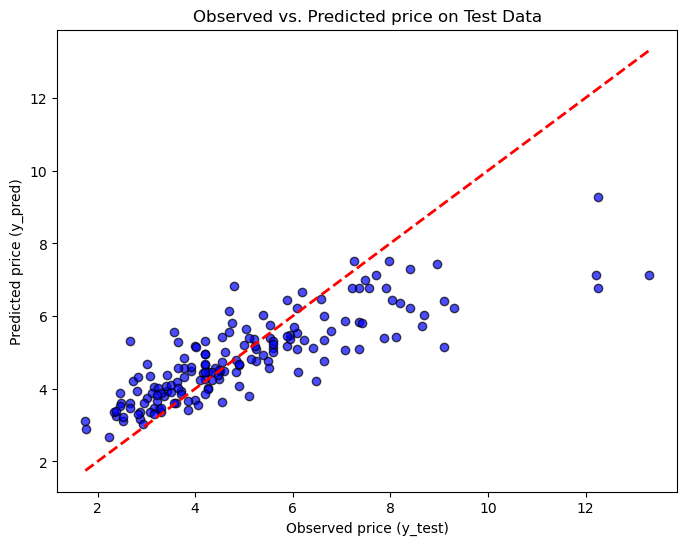

In [66]:
clf = Lasso(alpha=0.1)

clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Observed vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', lw=2)  # Ideal line
plt.xlabel("Observed price (y_test)")
plt.ylabel("Predicted price (y_pred)")
plt.title("Observed vs. Predicted price on Test Data")
plt.show()

In [67]:
my_pwlf = pwlf.PiecewiseLinFit(X_train, y_train)
d = my_pwlf.fit_with_breaks([min(y_train), 0.039, 0.10, max(x)])

NameError: name 'pwlf' is not defined

In [ ]:
import pwlf
# Given some data, fit the model
my_pwlf = pwlf.PiecewiseLinFit(X_train, y_train)
breaks = my_pwlf.fit(2)

# Make predictions on the test set
y_pred = my_pwlf.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Observed vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', lw=2)  # Ideal line
plt.xlabel("Observed price (y_test)")
plt.ylabel("Predicted price (y_pred)")
plt.title("Observed vs. Predicted price on Test Data")
plt.show()



In [ ]:
X_train

In [ ]:
!pip install pwlf